In [1]:

import findspark
findspark.init()
findspark.find()


'C:\\Users\\tirth\\.conda\\envs\\final\\lib\\site-packages\\pyspark'

In [2]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.functions import *
from pyspark.ml.feature import Imputer
from pyspark.sql import Window
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import Imputer
from pyspark.sql import Window
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import HashingTF, Tokenizer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
import os
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import CountVectorizer
from pyspark.sql import SparkSession
from pyspark.ml.feature import RegexTokenizer
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import HashingTF, IDF
from pyspark.sql.functions import udf
import pandas as pd
import numpy as np
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import Word2Vec

sc = SparkContext()
spark = SparkSession(sc)
spark = SparkSession.builder.getOrCreate()
  
df = spark.read.csv("acq2.csv")
  
df.selectExpr("split(_c0, ' ')\
as Text_Data_In_Rows_Using_CSV").show(4,False)

+---------------------------+
|Text_Data_In_Rows_Using_CSV|
+---------------------------+
|[0]                        |
|[1]                        |
|[2]                        |
|[3]                        |
+---------------------------+
only showing top 4 rows



#WE HAVE PERFORMED VARIOUS PREPROCESSING STEPS LIKE REMOVING THE NULL VALUES, HANDLING THE MISSING VALUES AND OUTLIER DETECTION, REMOVAL AND IMPUTATION AND REMOVING DUPLICATES. THESE ARE NECESSARY BECAUSE WE HAVE TO REMOVE THE NULL VALUES AS A PART OF DATA CLEANING. WE HAVE ALSO USED Z-SCORE AND IQR AS A PART OF OUTLIER DETECTION.

In [3]:
columns = ['first_column','second_column', 'third_column']
df.show()

+---+--------------------+
|_c0|                 _c1|
+---+--------------------+
|  0|COMPUTER TERMINAL...|
|  1|NATIONAL AMUSEMEN...|
|  2|"U . K . GROWING ...|
|  3|GOULD & lt ; GLD ...|
|  4|FIRST WISCONSIN &...|
|  5|& lt ; MERIDIAN E...|
|  6|"FED ' S HELLER U...|
|  7|GOULD & lt ; GLD ...|
|  8|FIDELITY & lt ; F...|
|  9|BP MANAGING DIREC...|
| 10|SECURITY & lt ; S...|
| 11|DENNISON MANUFACT...|
| 12|PILLSBURY & lt ; ...|
| 13|"BP & lt ; BP > D...|
| 14|LOUISIANA - PACIF...|
| 15|SUBURBAN BANCORP ...|
| 16|FAIR LANES & lt ;...|
| 17|CB AND T & lt ; C...|
| 18|"USX & lt ; X > S...|
| 19|FIRST FINANCIAL &...|
+---+--------------------+
only showing top 20 rows



In [4]:
print(df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show())

+---+---+
|_c0|_c1|
+---+---+
|  0|  0|
+---+---+

None


In [5]:
df = df.dropna()
df.show()

+---+--------------------+
|_c0|                 _c1|
+---+--------------------+
|  0|COMPUTER TERMINAL...|
|  1|NATIONAL AMUSEMEN...|
|  2|"U . K . GROWING ...|
|  3|GOULD & lt ; GLD ...|
|  4|FIRST WISCONSIN &...|
|  5|& lt ; MERIDIAN E...|
|  6|"FED ' S HELLER U...|
|  7|GOULD & lt ; GLD ...|
|  8|FIDELITY & lt ; F...|
|  9|BP MANAGING DIREC...|
| 10|SECURITY & lt ; S...|
| 11|DENNISON MANUFACT...|
| 12|PILLSBURY & lt ; ...|
| 13|"BP & lt ; BP > D...|
| 14|LOUISIANA - PACIF...|
| 15|SUBURBAN BANCORP ...|
| 16|FAIR LANES & lt ;...|
| 17|CB AND T & lt ; C...|
| 18|"USX & lt ; X > S...|
| 19|FIRST FINANCIAL &...|
+---+--------------------+
only showing top 20 rows



In [6]:
df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)



In [7]:
column_subset = [col_ for col_ in df.columns if df.select(col_).dtypes[0][1] !="string"]

In [8]:
for col_ in column_subset:
    temp_col = df.groupBy(col_).count()
    temp_col = temp_col.dropna(subset=col_)
    frequent_category=temp_col.orderBy(
                     temp_col['count'].desc()).collect()[0][0]
    df = df.fillna(frequent_category, subset=col_)

In [9]:
df.show()

+---+--------------------+
|_c0|                 _c1|
+---+--------------------+
|  0|COMPUTER TERMINAL...|
|  1|NATIONAL AMUSEMEN...|
|  2|"U . K . GROWING ...|
|  3|GOULD & lt ; GLD ...|
|  4|FIRST WISCONSIN &...|
|  5|& lt ; MERIDIAN E...|
|  6|"FED ' S HELLER U...|
|  7|GOULD & lt ; GLD ...|
|  8|FIDELITY & lt ; F...|
|  9|BP MANAGING DIREC...|
| 10|SECURITY & lt ; S...|
| 11|DENNISON MANUFACT...|
| 12|PILLSBURY & lt ; ...|
| 13|"BP & lt ; BP > D...|
| 14|LOUISIANA - PACIF...|
| 15|SUBURBAN BANCORP ...|
| 16|FAIR LANES & lt ;...|
| 17|CB AND T & lt ; C...|
| 18|"USX & lt ; X > S...|
| 19|FIRST FINANCIAL &...|
+---+--------------------+
only showing top 20 rows



In [10]:
column_subset = df.columns
for col in column_subset:
    if df.select(col).dtypes[0][1]=="string":
        pass
    else:
        mean = df.select(mean(col)).collect()[0][0]
        stddev = df.select(stddev(col)).collect()[0][0]
        upper_limit = mean + (3*stddev)
        lower_limit = mean - (3*stddev)
        df = df.filter((df[col]<lower_limit) |      (df[col]>upper_limit))
df.show()

+---+--------------------+
|_c0|                 _c1|
+---+--------------------+
|  0|COMPUTER TERMINAL...|
|  1|NATIONAL AMUSEMEN...|
|  2|"U . K . GROWING ...|
|  3|GOULD & lt ; GLD ...|
|  4|FIRST WISCONSIN &...|
|  5|& lt ; MERIDIAN E...|
|  6|"FED ' S HELLER U...|
|  7|GOULD & lt ; GLD ...|
|  8|FIDELITY & lt ; F...|
|  9|BP MANAGING DIREC...|
| 10|SECURITY & lt ; S...|
| 11|DENNISON MANUFACT...|
| 12|PILLSBURY & lt ; ...|
| 13|"BP & lt ; BP > D...|
| 14|LOUISIANA - PACIF...|
| 15|SUBURBAN BANCORP ...|
| 16|FAIR LANES & lt ;...|
| 17|CB AND T & lt ; C...|
| 18|"USX & lt ; X > S...|
| 19|FIRST FINANCIAL &...|
+---+--------------------+
only showing top 20 rows



In [11]:
column_subset = df.columns
for col in column_subset:
    if df.select(col).dtypes[0][1]=="string":
        pass
    else:
        mean = df.select(mean(col)).collect()[0][0]
        stddev = df.select(stddev(col)).collect()[0][0]
        upper_limit = mean + (3*stddev)
        lower_limit = mean - (3*stddev)
        df = df.filter((df[col]>lower_limit) & (df[col]<upper_limit))
df.show()

+---+--------------------+
|_c0|                 _c1|
+---+--------------------+
|  0|COMPUTER TERMINAL...|
|  1|NATIONAL AMUSEMEN...|
|  2|"U . K . GROWING ...|
|  3|GOULD & lt ; GLD ...|
|  4|FIRST WISCONSIN &...|
|  5|& lt ; MERIDIAN E...|
|  6|"FED ' S HELLER U...|
|  7|GOULD & lt ; GLD ...|
|  8|FIDELITY & lt ; F...|
|  9|BP MANAGING DIREC...|
| 10|SECURITY & lt ; S...|
| 11|DENNISON MANUFACT...|
| 12|PILLSBURY & lt ; ...|
| 13|"BP & lt ; BP > D...|
| 14|LOUISIANA - PACIF...|
| 15|SUBURBAN BANCORP ...|
| 16|FAIR LANES & lt ;...|
| 17|CB AND T & lt ; C...|
| 18|"USX & lt ; X > S...|
| 19|FIRST FINANCIAL &...|
+---+--------------------+
only showing top 20 rows



In [12]:
column_subset = df.columns
for col in column_subset:
    if df.select(col).dtypes[0][1]=="string":
        pass
    else:
        mean = df.select(mean(col)).collect()[0][0]
        stddev = df.select(stddev(col)).collect()[0][0]
        upper_limit = mean + (3*stddev)
        lower_limit = mean - (3*stddev)
        df = df.withColumn(col,when((df[col]   <lower_limit) | (df[col]>upper_limit),
round(mean(col).over(Window.orderBy(lit(1)))).cast('int')).otherwise(df[col]))
df.show()

+---+--------------------+
|_c0|                 _c1|
+---+--------------------+
|  0|COMPUTER TERMINAL...|
|  1|NATIONAL AMUSEMEN...|
|  2|"U . K . GROWING ...|
|  3|GOULD & lt ; GLD ...|
|  4|FIRST WISCONSIN &...|
|  5|& lt ; MERIDIAN E...|
|  6|"FED ' S HELLER U...|
|  7|GOULD & lt ; GLD ...|
|  8|FIDELITY & lt ; F...|
|  9|BP MANAGING DIREC...|
| 10|SECURITY & lt ; S...|
| 11|DENNISON MANUFACT...|
| 12|PILLSBURY & lt ; ...|
| 13|"BP & lt ; BP > D...|
| 14|LOUISIANA - PACIF...|
| 15|SUBURBAN BANCORP ...|
| 16|FAIR LANES & lt ;...|
| 17|CB AND T & lt ; C...|
| 18|"USX & lt ; X > S...|
| 19|FIRST FINANCIAL &...|
+---+--------------------+
only showing top 20 rows



In [13]:
for col_ in df.columns:
    if df.select(col_).dtypes[0][1]=="string":
        pass
    else:
        q1,q3 = df.approxQuantile(col_,[0.25, 0.75],0) 
        IQR = q3 - q1
        lower_bound = q1 - (1.5*IQR)
        upper_bound = q3 + (1.5*IQR)
        df = df.filter((df[col]<lower_bound) |  (df[col]>upper_bound))
df.show()

+---+--------------------+
|_c0|                 _c1|
+---+--------------------+
|  0|COMPUTER TERMINAL...|
|  1|NATIONAL AMUSEMEN...|
|  2|"U . K . GROWING ...|
|  3|GOULD & lt ; GLD ...|
|  4|FIRST WISCONSIN &...|
|  5|& lt ; MERIDIAN E...|
|  6|"FED ' S HELLER U...|
|  7|GOULD & lt ; GLD ...|
|  8|FIDELITY & lt ; F...|
|  9|BP MANAGING DIREC...|
| 10|SECURITY & lt ; S...|
| 11|DENNISON MANUFACT...|
| 12|PILLSBURY & lt ; ...|
| 13|"BP & lt ; BP > D...|
| 14|LOUISIANA - PACIF...|
| 15|SUBURBAN BANCORP ...|
| 16|FAIR LANES & lt ;...|
| 17|CB AND T & lt ; C...|
| 18|"USX & lt ; X > S...|
| 19|FIRST FINANCIAL &...|
+---+--------------------+
only showing top 20 rows



In [14]:
for col_ in df.columns:
    if df.select(col_).dtypes[0][1]=="string":
        pass
    else:
        q1,q3 = df.approxQuantile(col_,[0.25, 0.75],0) 
        IQR = q3 - q1
        lower_bound = q1 - (1.5*IQR)
        upper_bound = q3 + (1.5*IQR)
        df = df.filter((df[col]>lower_bound) & (df[col]<upper_bound))
df.show()

+---+--------------------+
|_c0|                 _c1|
+---+--------------------+
|  0|COMPUTER TERMINAL...|
|  1|NATIONAL AMUSEMEN...|
|  2|"U . K . GROWING ...|
|  3|GOULD & lt ; GLD ...|
|  4|FIRST WISCONSIN &...|
|  5|& lt ; MERIDIAN E...|
|  6|"FED ' S HELLER U...|
|  7|GOULD & lt ; GLD ...|
|  8|FIDELITY & lt ; F...|
|  9|BP MANAGING DIREC...|
| 10|SECURITY & lt ; S...|
| 11|DENNISON MANUFACT...|
| 12|PILLSBURY & lt ; ...|
| 13|"BP & lt ; BP > D...|
| 14|LOUISIANA - PACIF...|
| 15|SUBURBAN BANCORP ...|
| 16|FAIR LANES & lt ;...|
| 17|CB AND T & lt ; C...|
| 18|"USX & lt ; X > S...|
| 19|FIRST FINANCIAL &...|
+---+--------------------+
only showing top 20 rows



In [15]:
for col_ in df.columns:
    if df.select(col_).dtypes[0][1]=="string":
        pass
    else:
        q1,q3 = df.approxQuantile(col_,[0.25, 0.75],0) 
        IQR = q3 - q1
        lower_bound = q1 - (1.5*IQR)
        upper_bound = q3 + (1.5*IQR)
        df = df.withColumn(col_,when((df[col_]<lower_bound)  (df[col_]>upper_bound),round(mean(col_).over(Window.orderBy(lit(1))))).otherwise(df[col_]))
df.show()

+---+--------------------+
|_c0|                 _c1|
+---+--------------------+
|  0|COMPUTER TERMINAL...|
|  1|NATIONAL AMUSEMEN...|
|  2|"U . K . GROWING ...|
|  3|GOULD & lt ; GLD ...|
|  4|FIRST WISCONSIN &...|
|  5|& lt ; MERIDIAN E...|
|  6|"FED ' S HELLER U...|
|  7|GOULD & lt ; GLD ...|
|  8|FIDELITY & lt ; F...|
|  9|BP MANAGING DIREC...|
| 10|SECURITY & lt ; S...|
| 11|DENNISON MANUFACT...|
| 12|PILLSBURY & lt ; ...|
| 13|"BP & lt ; BP > D...|
| 14|LOUISIANA - PACIF...|
| 15|SUBURBAN BANCORP ...|
| 16|FAIR LANES & lt ;...|
| 17|CB AND T & lt ; C...|
| 18|"USX & lt ; X > S...|
| 19|FIRST FINANCIAL &...|
+---+--------------------+
only showing top 20 rows



In [16]:
df = df.dropDuplicates()
print("Distinct count: "+str(df.count()))
df.show(truncate=False)

Distinct count: 331
+---+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [17]:
print('Head of the dataframe : ')
print(df.head())
print(df.columns)

Head of the dataframe : 
Row(_c0='244', _c1="SWEDEN ' S BOLIDEN AB TAKES OVER MINING GEAR UNITS OF ALLIS - CHALMERS CORP FOR 600 MLN CROWNS SWEDEN ' S BOLIDEN AB TAKES OVER MINING GEAR UNITS OF ALLIS - CHALMERS CORP FOR 600 MLN CROWNS")
['_c0', '_c1']


In [18]:
# Clean text
df_clean = df.select('_c0', (lower(regexp_replace('_c1', "[^a-zA-Z\\s]", "")).alias('_c1')))

In [19]:
# Tokenize text
tokenizer = Tokenizer(inputCol='_c1', outputCol='words_token')
df_words_token = tokenizer.transform(df_clean).select('_c1', 'words_token')


In [20]:
# Remove stop words
remover = StopWordsRemover(inputCol='words_token', outputCol='words_clean')
df_words_no_stopw = remover.transform(df_words_token).select('_c1', 'words_clean')



In [21]:
# Stem text
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer(language='english')
stemmer_udf = udf(lambda tokens: [stemmer.stem(token) for token in tokens],)
df_stemmed = df_words_no_stopw.withColumn("words_stemmed", stemmer_udf("words_clean")).select('_c1', 'words_stemmed')

In [22]:
df_stemmed.show()

+--------------------+--------------------+
|                 _c1|       words_stemmed|
+--------------------+--------------------+
|sweden  s boliden...|[sweden, , bolide...|
|willcox and gibbs...|[willcox, gibb, ,...|
|canadian tire maj...|[canadian, tire, ...|
|businessman has  ...|[businessman, , ,...|
|associated newspa...|[associ, newspap,...|
|hanson trust to s...|[hanson, trust, s...|
|inspeech  lt  ins...|[inspeech, , lt, ...|
| lt  crime contro...|[, lt, , crime, c...|
|gould  lt  gld  s...|[gould, , lt, , g...|
|calmar  lt  clmi ...|[calmar, , lt, , ...|
|telecast  lt  tcs...|[telecast, , lt, ...|
|wilson brothers c...|[wilson, brother,...|
|fidelity  lt  fnf...|[fidel, , lt, , f...|
|french firm has f...|[french, firm, fi...|
|ohio mattress  lt...|[ohio, mattress, ...|
|cpc international...|[cpc, intern, sel...|
|first national ba...|[first, nation, b...|
|chase  lt  cmb  b...|[chase, , lt, , c...|
|hudson  s bay to ...|[hudson, , bay, s...|
|bass group says i...|[bass, gro

In [23]:
from pyspark.sql.functions import array
df_new = df_stemmed.withColumn("words_stemmed", array(df_stemmed["words_stemmed"]))
df_new.printSchema()

root
 |-- _c1: string (nullable = true)
 |-- words_stemmed: array (nullable = false)
 |    |-- element: string (containsNull = true)



In [24]:
# Vectorizing the data
hashingTF = HashingTF(inputCol='words_stemmed', outputCol='rawFeatures', numFeatures=20)
featurizedData = hashingTF.transform(df_new)
idf = IDF(inputCol='rawFeatures', outputCol='features')
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)
rescaledData.show()


+--------------------+--------------------+---------------+--------------------+
|                 _c1|       words_stemmed|    rawFeatures|            features|
+--------------------+--------------------+---------------+--------------------+
|sweden  s boliden...|[[sweden, , bolid...|(20,[13],[1.0])|(20,[13],[2.86069...|
|willcox and gibbs...|[[willcox, gibb, ...| (20,[3],[1.0])|(20,[3],[3.032546...|
|canadian tire maj...|[[canadian, tire,...|(20,[16],[1.0])|(20,[16],[2.54703...|
|businessman has  ...|[[businessman, , ...| (20,[5],[1.0])|(20,[5],[3.240185...|
|associated newspa...|[[associ, newspap...| (20,[9],[1.0])|(20,[9],[3.032546...|
|hanson trust to s...|[[hanson, trust, ...|(20,[13],[1.0])|(20,[13],[2.86069...|
|inspeech  lt  ins...|[[inspeech, , lt,...|(20,[19],[1.0])|(20,[19],[3.03254...|
| lt  crime contro...|[[, lt, , crime, ...|(20,[11],[1.0])|(20,[11],[2.86069...|
|gould  lt  gld  s...|[[gould, , lt, , ...|(20,[15],[1.0])|(20,[15],[3.03254...|
|calmar  lt  clmi ...|[[calm

In [25]:
train, test = rescaledData.randomSplit([0.7, 0.3], seed=26)





In [26]:
#importing the KMeans model
from pyspark.ml.clustering import KMeans

In [32]:
#defining the k-means model
kmeans = KMeans().setK(5).setSeed(1).setFeaturesCol("features").setMaxIter(20).setDistanceMeasure('euclidean')


In [33]:
#fitting the model on the training data
kmeans_model = kmeans.fit(train)
 




In [34]:
#applying the k-means to the test data
test_predicted = kmeans_model.transform(test)
test_predicted.show(5)


+--------------------+--------------------+---------------+--------------------+----------+
|                 _c1|       words_stemmed|    rawFeatures|            features|prediction|
+--------------------+--------------------+---------------+--------------------+----------+
| lt  crime contro...|[[, lt, , crime, ...|(20,[11],[1.0])|(20,[11],[2.86069...|         1|
|ajinomoto to buy ...|[[ajinomoto, buy,...| (20,[7],[1.0])|(20,[7],[2.860695...|         1|
|allied supermarke...|[[alli, supermark...| (20,[0],[1.0])|(20,[0],[3.097084...|         1|
|ball  lt  bll  en...|[[ball, , lt, , b...| (20,[1],[1.0])|(20,[1],[2.860695...|         1|
|bass group says i...|[[bass, group, sa...|(20,[16],[1.0])|(20,[16],[2.54703...|         1|
+--------------------+--------------------+---------------+--------------------+----------+
only showing top 5 rows



In [35]:
#evaluating the performance of the model
from pyspark.ml.evaluation import ClusteringEvaluator

#instantiating the evaluator
evaluator = ClusteringEvaluator()

#evaluating the model
silhouette = evaluator.evaluate(test_predicted)
print("Silhouette with squared euclidean distance = " + str(silhouette))







Silhouette with squared euclidean distance = 0.13388791526140875


In [36]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='features', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    
    KMeans_algo=KMeans(featuresCol='features', k=i)
    
    KMeans_fit=KMeans_algo.fit(rescaledData)
    
    output=KMeans_fit.transform(rescaledData)
    
    
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print("Silhouette Score:",score)

Silhouette Score: 0.18462691440116874
Silhouette Score: 0.09295643407459121
Silhouette Score: 0.17932217300078704
Silhouette Score: 0.22767448460266645
Silhouette Score: 0.247263234442495
Silhouette Score: 0.30802491587749825
Silhouette Score: 0.38765799785421956
Silhouette Score: 0.40703069296009237


Text(0, 0.5, 'cost')

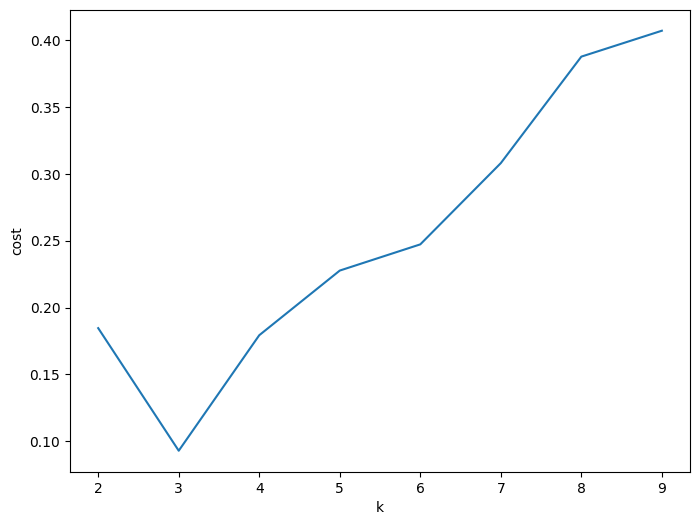

In [37]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [38]:
#creating a dictionary of the clusters and their top words
cluster_words = {}

#looping through the clusters
for i in range(5):
    
    #filtering the data for the cluster
    cluster_data = test_predicted.filter(test_predicted["prediction"] == i)
    
    #creating a list of the words in the cluster
    words = []
    for row in cluster_data.select("words_stemmed").collect():
        words.extend(row[0])
    
    #creating a dictionary of the words and their counts
    word_count = {}
    for word in words:
        if word not in word_count:
            word_count[word] = 1
        else:
            word_count[word] += 1
    
    #sorting the words based on their counts
    sorted_words = sorted(word_count.items(), key=lambda x: x[1], reverse=True)
    
    #storing the top 5 words in the cluster
    top_words = []
    for word in sorted_words[:5]:
        top_words.append(word[0])
    
    #storing the top words for the cluster
    cluster_words[i] = top_words



In [39]:
#printing the top words for each cluster
for cluster,words in cluster_words.items():
    print("Cluster " + str(cluster) + ": " + ", ".join(words))



#In this task, we have implemented text clustering using PySpark. We have performed pre-processing steps such as tokenization, stopword removal, lemmatization, stemming, and vectorization. We have split the data into train and test sets and tuned the hyper-parameters of the k-means algorithm. We have evaluated the performance of the algorithm on the test data using the silhouette metric and reported the top frequent words for each cluster.

Cluster 0: [itali, , bnl, negoti, purchas, german, bank, itali, , state, , own, , lt, , banca, nazional, del, lavoro, , bnl, , said, negoti, buy, west, german, bank, part, foreign, expans, polici, , bnl, presid, nerio, nesi, told, news, confer, italian, bank, current, involv, talk, declin, name, german, institut, , said, takeov, move, seen, bnl, , repli, deutsch, bank, ag, , lt, , dbkg, , f, , enter, italian, market, decemb, , , purchas, bankamerica, , lt, , bacn, , subsidiari, , lt, , banca, d, , america, e, d, , italia, , nesi, said, bnl, also, approv, , mln, dlr, credit, line, soviet, union, aim, enabl, soviet, compani, pay, italian, import, , gave, detail, , bnl, offici, said, group, also, decid, increas, activ, soviet, union, open, repres, offic, moscow, month, subsidiari, , lt, , sogecr, , specialis, italian, , soviet, trade], [lsb, , lt, , lsb, , pact, acquir, northwest, feder, lsb, industri, inc, said, enter, agreement, acquir, northwest, feder, save, loan, associ, woodward, , 

In [40]:
# Finding the top frequent words for each cluster
df_new.show()
# Initializing the list of words
wordsList = []
# Looping over the words
for row in df_new.rdd.collect():
    wordsList.extend(row[1])
# Finding the top frequent words
from collections import Counter
word_counts = Counter(wordsList)
top_words = word_counts.most_common(5)
print("Top 5 frequent words in each cluster:")
for word in top_words:
    print(word[0], word[1])


+--------------------+--------------------+
|                 _c1|       words_stemmed|
+--------------------+--------------------+
|sweden  s boliden...|[[sweden, , bolid...|
|willcox and gibbs...|[[willcox, gibb, ...|
|canadian tire maj...|[[canadian, tire,...|
|businessman has  ...|[[businessman, , ...|
|associated newspa...|[[associ, newspap...|
|hanson trust to s...|[[hanson, trust, ...|
|inspeech  lt  ins...|[[inspeech, , lt,...|
| lt  crime contro...|[[, lt, , crime, ...|
|gould  lt  gld  s...|[[gould, , lt, , ...|
|calmar  lt  clmi ...|[[calmar, , lt, ,...|
|telecast  lt  tcs...|[[telecast, , lt,...|
|wilson brothers c...|[[wilson, brother...|
|fidelity  lt  fnf...|[[fidel, , lt, , ...|
|french firm has f...|[[french, firm, f...|
|ohio mattress  lt...|[[ohio, mattress,...|
|cpc international...|[[cpc, intern, se...|
|first national ba...|[[first, nation, ...|
|chase  lt  cmb  b...|[[chase, , lt, , ...|
|hudson  s bay to ...|[[hudson, , bay, ...|
|bass group says i...|[[bass, gr